### Econ 430 Group member:
### Kewei He, Kevin Zhao, Minghao Gu, Zirui Liu

### I. Motivation for the projects:

### In the realm of statistical analysis, the exploration and interpretation of datasets provide valuable insights into underlying trends and relationships. This report delves into a comprehensive statistical examination of a dataset, likely sourced from the world of sports, as indicated by references to variables such as 'lsalary', 'gamesyr', 'hrunsyr', and player positions like 'outfield' and 'catcher'. The primary objective is to identify significant predictors and understand their impact on players' salaries.

### II. Data Description:
### This report examines a dataset composed of professional athletes' statistics, likely from a baseball context. It features a range of variables including 'lsalary', which presumably represents the logarithm of players' salaries, indicating their earnings in a more analyzable form. Other key numerical variables include 'gamesyr' and 'hrunsyr', suggesting the number of games played and home runs hit per year, respectively. Additionally, the dataset categorizes players into positions such as 'outfield' and 'catcher', offering a qualitative aspect for comparison. The data appears to be comprehensive, encompassing diverse aspects of player performance and characteristics, which are essential for a thorough analysis of salary determinants. Each variable contributing to a multifaceted understanding of what influences an athlete's salary in professional sports.



### Variables Included in the Analysis:
 ####   salary: 1993 season salary
 #### teamsal: team payroll
#### years: years in major leagues
#### career strike outs
#### sbases: career stolen bases
#### fldperc: career fielding perc
#### outfield: =1 if outfield
#### catcher: =1 if catcher
#### black: =1 if black
#### gamesyr: games per year in league
#### hrunsyr: home runs per year
#### atbatsyr: at bats per year
#### slugavg: career slugging average
#### rbisyr: rbis per year
#### sbasesyr: stolen bases per year
#### runsyr: runs scored per year
#### lsalary: log(salary)

### III.Working process:
#### 1.Variable Selection:
#### Using the Boruta Algorithm, we find that the top quantitative predictors are 'atbatsyr', 'slugavg', 'runsyr', 'so', 'rbisyr', 'gamesyr', 'years'and then we test the factor variable, outfield,catcher, black are significant. Based on analysis above. the predictors we will use are as the followings: 'lsalary','atbatsyr', 'slugavg', 'runsyr', 'so', 'rbisyr', 'gamesyr', 'years','outfield','catcher','black'.

#### 2. Descriptive Analysis: 
#### we applied histograms, quantile plots, correlation plots to have a visual representation of the distribution of each variable. we find that the lsalary subjects to the reciprocal	distribution, atbatsyr subjects to genhalflogistic	distribution, slugavg subject to fisk distribution, runsyr subject to beta distribution, so subject to exponational distribution, rbisyr subject to genhalflogistic	distribution, gamesyr subject to gausshyper distribution and years subject to truncnorm	distribution
#### After harvey_collier test, there's no non-linearities within the variables,we would perform  Box-Cox scale power transformation to make them linear Including non-linear variables in linear regression would result in Biased Parameter Estimates
#### By checking cook's distance plot we find there seems to be someoutliers, we decide to remove them. there is no missing value in our data set.
#### We also payed close attention in detecting missing values in our dataset. Fortunately, all the variables we selected for the model do not contain any missing value. 

#### 3. Model Building and Selection 
#### We first used the Mellow's CP to identify the best combination of independent variables to include in our ols regression 
#### To address for multicollinearity, we calculated VIFs for each variable and removed the ones that were over the threshhold 
#### Next, we tested if our current model is misspecified using the ramey reset test. With a p-value less than 0.05, we conculded that the model can be improved by adding higher order terms and interaction terms. We attempted to add new variables (so**2), (rbisyr**2), (years**2), so*(outfield+catcher), and kept the ones that are statistically signigicent. By runing the the ramey reset test again, we are able to conclude that the updated model: lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)  is now without misspacification. This prosses also helped reducing AIC and BIC along the way .
#### We determined that heteroskedasticity for having a less than 0.05 p-value from the BP test as well as from the spread plot. To address that, we decided to use FGLS to replace the original OLS model. Both residual plot and QQ plot proved that residuals have  constant distribution for the updated FGLS model. 
#### By far the FGLS model has the lowest AIC and BIC score, thus we selected it as the best model
#### To test the robustness of our estimates, we used both bootstrapping and crossvalidation. With normally distributed bootstrapping statistics and constant MSE scores from coss-validation, we are confident that our estimates are robust 

### IV.Results and Interpretation:
#### From results of the FGLS regression, we found that one more career runs batted in is assoicated with 4.78 percent increase in the player's current year annual salary(1993). On top of that, there is also a statistically significant association between the number of years a player has played in the Major league and his salary. With every additional year of experience in the league, a player would get a 33.44 percent increae in his current year(1993) salary. The position on the field has no statistically significant to the salary. 

#### From researching for any marginal effect, we identified that as a player is accumulating his carear stats for run batted in, he is expecting to receive higher salaries each year. However, the relationship between number of years played in the league and expected annual salary is quadratic. Expected salary is going to top at around players' 10th year in the Major league and gradually going down as they were getting up on their ages. 

### V. References 
#### Our data was obtained from MLB1 dataset from the wooldridge package 
#### Code structure for discriptive analysis from Regression_Examples2.ipynb; Boruta and Mallow's CP algorithm from 23f_lec4.ipynb; BP test, FGLS, Spread level plots algorithm from 23f_lec6_heteroscadasticity.ipynb; VIF test and RESET test from Fall2023_w6.pdf

In [1]:
import wooldridge as woo
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
import seaborn as sns
import math
import pandas as pd
import rpy2
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from RegscorePy import mallow
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
# Load data
mlb1 = woo.data('mlb1')
mlb1


,salary,teamsal,nl,years,games,atbats,runs,hits,doubles,triples,...,runsyr,percwhte,percblck,perchisp,blckpb,hispph,whtepw,blckph,hisppb,lsalary
0,6329213.0,38407380.0,1,12,1705,6705,1076,1939,320,67,...,89.666664,70.277969,18.844229,10.877804,0.000000,0.000000,70.277969,0.000000,0.000000,15.660686
1,3375000.0,38407380.0,1,8,918,3333,407,863,156,38,...,50.875000,70.277969,18.844229,10.877804,18.844229,0.000000,0.000000,10.877804,0.000000,15.031906
2,3100000.0,38407380.0,1,5,751,2807,370,840,148,18,...,74.000000,70.277969,18.844229,10.877804,0.000000,0.000000,70.277969,0.000000,0.000000,14.946913
3,2900000.0,38407380.0,1,8,1056,3337,405,816,143,18,...,50.625000,70.277969,18.844229,10.877804,0.000000,0.000000,70.277969,0.000000,0.000000,14.880221
4,1650000.0,38407380.0,1,12,1196,3603,437,928,19,16,...,36.416668,70.277969,18.844229,10.877804,18.844229,0.000000,0.000000,10.877804,0.000000,14.316286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,312000.0,35586456.0,0,5,439,1098,150,260,41,8,...,30.000000,73.149635,13.871621,12.978746,0.000000,0.000000,73.149635,0.000000,0.000000,12.650759
349,275000.0,35586456.0,0,2,211,700,63,183,32,1,...,31.500000,73.149635,13.871621,12.978746,0.000000,12.978746,0.000000,0.000000,13.871621,12.524527
350,250000.0,35586456.0,0,3,249,828,112,176,36,2,...,37.333332,73.149635,13.871621,12.978746,0.000000,0.000000,73.149635,0.000000,0.000000,12.429216
351,200000.0,35586456.0,0,6,667,2087,217,510,92,5,...,36.166668,73.149635,13.871621,12.978746,0.000000,0.000000,73.149635,0.000000,0.000000,12.206073


In [3]:
#Check if there are any missing observations
print(mlb1.isnull().any())

# Since there missing obs, count how many per variable
print(mlb1.isnull().sum())

salary      False
teamsal     False
nl          False
years       False
games       False
atbats      False
runs        False
hits        False
doubles     False
triples     False
hruns       False
rbis        False
bavg        False
bb          False
so          False
sbases      False
fldperc     False
frstbase    False
scndbase    False
shrtstop    False
thrdbase    False
outfield    False
catcher     False
yrsallst    False
hispan      False
black       False
whitepop     True
blackpop     True
hisppop      True
pcinc       False
gamesyr     False
hrunsyr     False
atbatsyr    False
allstar     False
slugavg     False
rbisyr      False
sbasesyr    False
runsyr      False
percwhte     True
percblck     True
perchisp     True
blckpb       True
hispph       True
whtepw       True
blckph       True
hisppb       True
lsalary     False
dtype: bool
salary       0
teamsal      0
nl           0
years        0
games        0
atbats       0
runs         0
hits         0
doubles      0
triples

In [45]:
# 1.a Using Boruta Algorithm to identify best quantitative predictors
from BorutaShap import BorutaShap
boruta_data = mlb1[['lsalary','teamsal','years','gamesyr','hrunsyr','atbatsyr','slugavg','rbisyr','sbasesyr','runsyr','bavg','so','sbases','fldperc']].copy()
x = boruta_data.iloc[:, 1:]
y = boruta_data['lsalary']

  0%|          | 0/50 [00:00<?, ?it/s]

7 attributes confirmed important: ['atbatsyr', 'slugavg', 'runsyr', 'so', 'rbisyr', 'gamesyr', 'years']
6 attributes confirmed unimportant: ['hrunsyr', 'teamsal', 'fldperc', 'sbasesyr', 'sbases', 'bavg']
0 tentative attributes remains: []


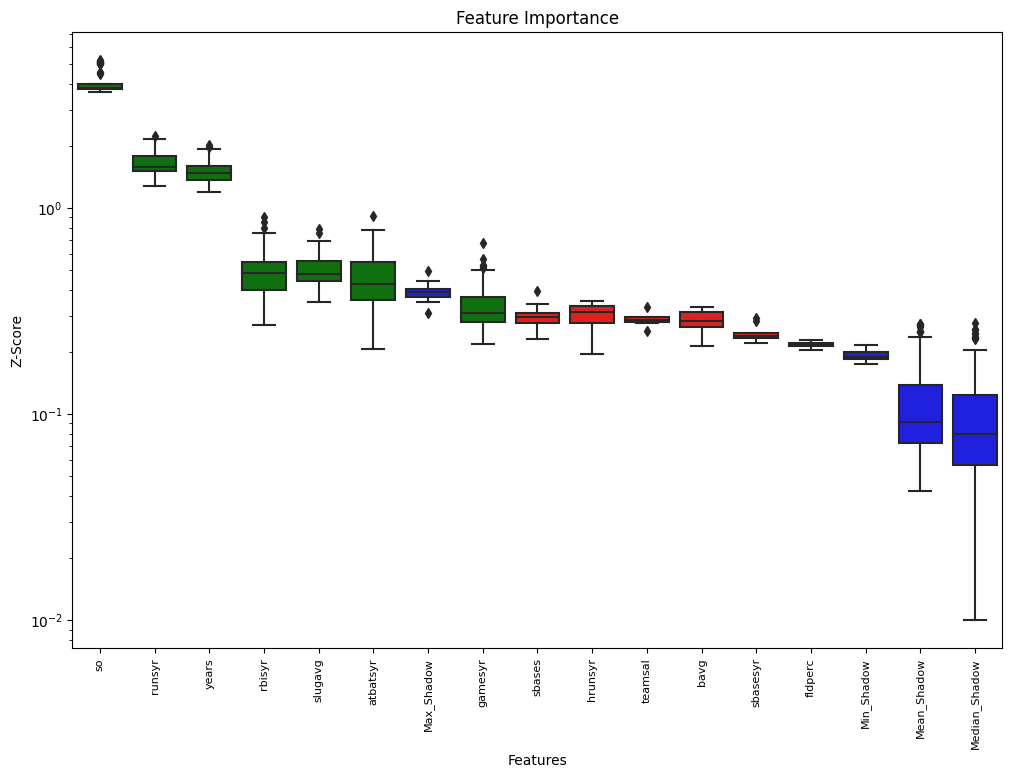

In [46]:
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=x, y=y, n_trials=50, random_state=0)
Feature_Selector.plot(which_features='all')
# the top quantitative predictors are ['atbatsyr', 'slugavg', 'runsyr', 'so', 'rbisyr', 'gamesyr', 'years']

In [39]:
# 1.b
# test whether the mean salaries are significantly different 
# ANOVA for 'nl' variable
f_value_nl, p_value_nl = stats.f_oneway(mlb1[mlb1['nl'] == 1]['lsalary'],
                                        mlb1[mlb1['nl'] == 0]['lsalary'])

# ANOVA for categorized 'frstbase' variable
f_value_frstbase, p_value_frstbase = stats.f_oneway(mlb1[mlb1['frstbase'] == 1]['lsalary'],
                                        mlb1[mlb1['frstbase'] == 0]['lsalary'])

# ANOVA for categorized 'scndbase' variable
f_value_scndbase, p_value_scndbase = stats.f_oneway(mlb1[mlb1['scndbase'] == 1]['lsalary'],
                                        mlb1[mlb1['scndbase'] == 0]['lsalary'])

# ANOVA for categorized 'shrtstop' variable
f_value_shrtstop, p_value_shrtstop = stats.f_oneway(mlb1[mlb1['shrtstop'] == 1]['lsalary'],
                                        mlb1[mlb1['shrtstop'] == 0]['lsalary'])


# ANOVA for categorized 'thrdbase' variable
f_value_thrdbase, p_value_thrdbase = stats.f_oneway(mlb1[mlb1['thrdbase'] == 1]['lsalary'],
                                        mlb1[mlb1['thrdbase'] == 0]['lsalary'])

# ANOVA for categorized 'outfield' variable
f_value_outfield, p_value_outfield = stats.f_oneway(mlb1[mlb1['outfield'] == 1]['lsalary'],
                                        mlb1[mlb1['outfield'] == 0]['lsalary'])


# ANOVA for categorized 'catcher' variable
f_value_catcher, p_value_catcher = stats.f_oneway(mlb1[mlb1['catcher'] == 1]['lsalary'],
                                        mlb1[mlb1['catcher'] == 0]['lsalary'])


# ANOVA for categorized 'hispan' variable
f_value_hispan, p_value_hispan = stats.f_oneway(mlb1[mlb1['hispan'] == 1]['lsalary'],
                                        mlb1[mlb1['hispan'] == 0]['lsalary'])

# ANOVA for categorized 'black' variable
f_value_black, p_value_black = stats.f_oneway(mlb1[mlb1['black'] == 1]['lsalary'],
                                        mlb1[mlb1['black'] == 0]['lsalary'])

print("ANOVA for 'nl' variable: F-Value =", f_value_nl, ", P-Value =", p_value_nl)
print("ANOVA for 'frstbase' variable: F-Value =", f_value_frstbase, ", P-Value =", p_value_frstbase)
print("ANOVA for 'scndbase' variable: F-Value =", f_value_scndbase, ", P-Value =", p_value_scndbase)
print("ANOVA for 'shrtstop' variable: F-Value =", f_value_shrtstop, ", P-Value =", p_value_shrtstop)
print("ANOVA for 'thrdbase' variable: F-Value =", f_value_thrdbase, ", P-Value =", p_value_thrdbase)
print("ANOVA for 'outfield' variable: F-Value =", f_value_outfield, ", P-Value =", p_value_outfield)
print("ANOVA for 'catcher' variable: F-Value =", f_value_catcher, ", P-Value =", p_value_catcher)
print("ANOVA for 'hispan' variable: F-Value =", f_value_hispan, ", P-Value =", p_value_hispan)
print("ANOVA for 'black' variable: F-Value =", f_value_black, ", P-Value =", p_value_black)

#outfield, catcher, black are statistically significant

ANOVA for 'nl' variable: F-Value = 0.8503333622750355 , P-Value = 0.35709144826281913
ANOVA for 'frstbase' variable: F-Value = 1.5159853303838025 , P-Value = 0.21905238037086922
ANOVA for 'scndbase' variable: F-Value = 0.027017413099898073 , P-Value = 0.8695346918553626
ANOVA for 'shrtstop' variable: F-Value = 2.203145769342624 , P-Value = 0.1386268590034302
ANOVA for 'thrdbase' variable: F-Value = 0.02589798430268818 , P-Value = 0.8722422921272547
ANOVA for 'outfield' variable: F-Value = 4.227232635070091 , P-Value = 0.040519339522800624
ANOVA for 'catcher' variable: F-Value = 6.419955855487262 , P-Value = 0.01171890724113572
ANOVA for 'hispan' variable: F-Value = 3.457545119803596 , P-Value = 0.06380026496493484
ANOVA for 'black' variable: F-Value = 7.626740612684254 , P-Value = 0.006053386116926106


In [4]:
# Based on analysis above. the predictors we will use are as the followings:
data = mlb1[['lsalary','atbatsyr', 'slugavg', 'runsyr', 'so', 'rbisyr', 'gamesyr', 'years','outfield','catcher','black']]
# data['so'] = np.log(data['so']+1)
# data['slugavg'] = np.log(data['slugavg']+1)

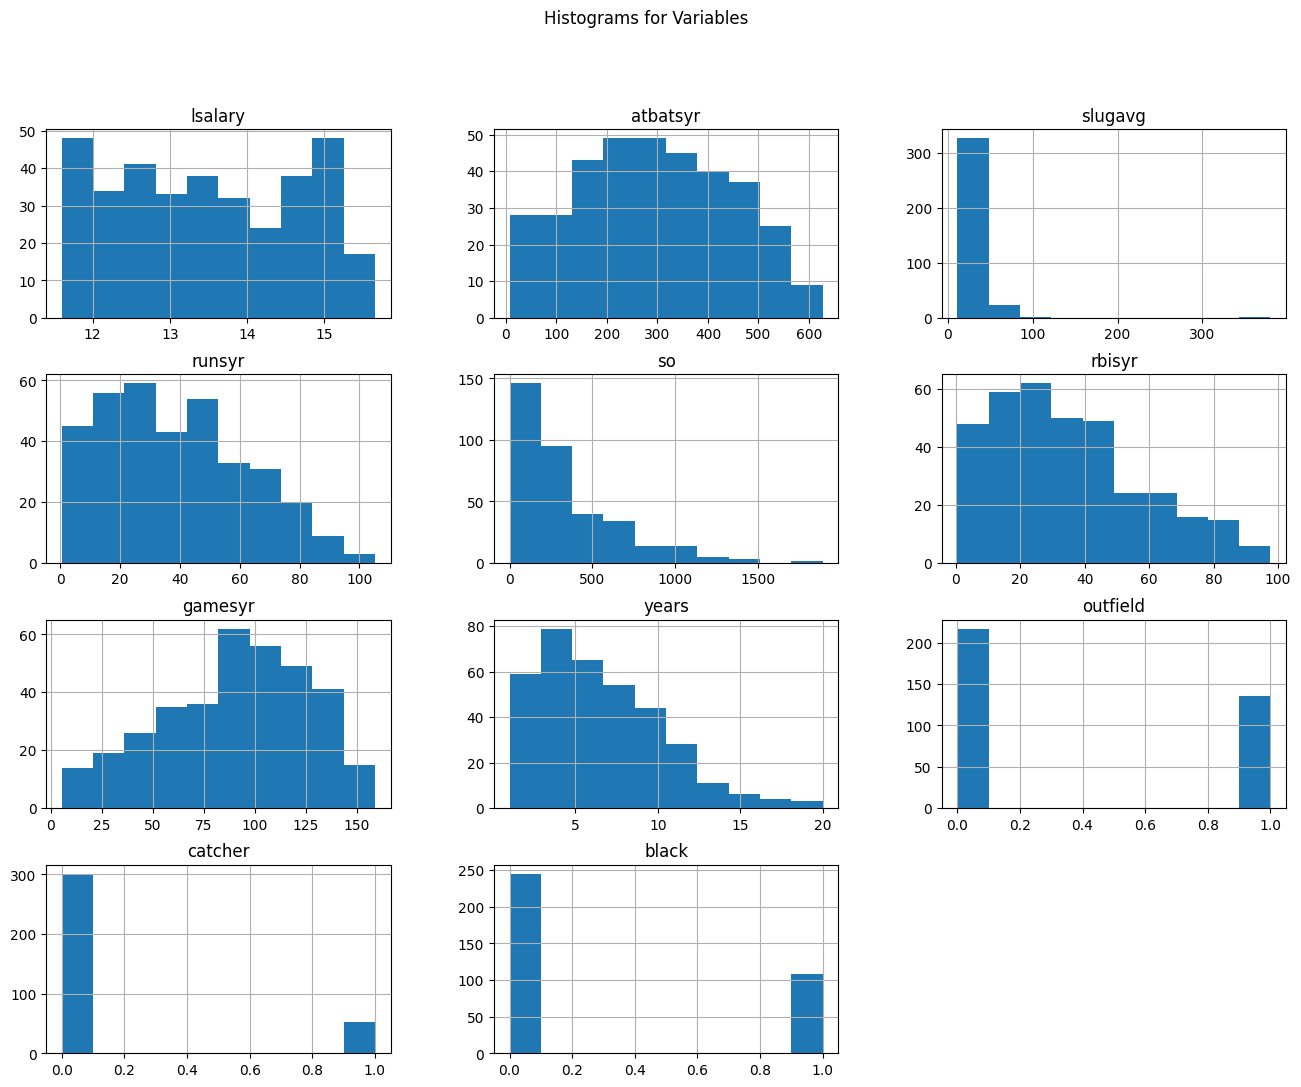

In [64]:
# 2.a histograms
data.hist(figsize = (16,12))
plt.suptitle('Histograms for Variables')
plt.show()

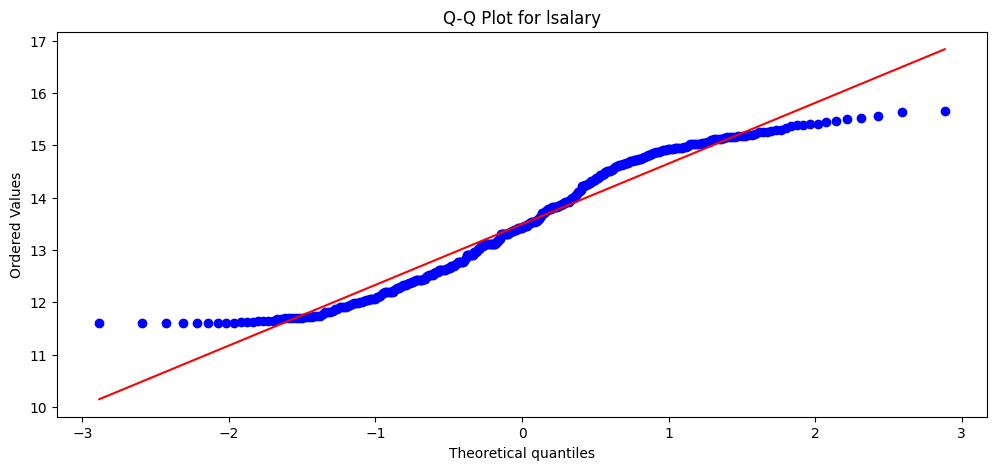

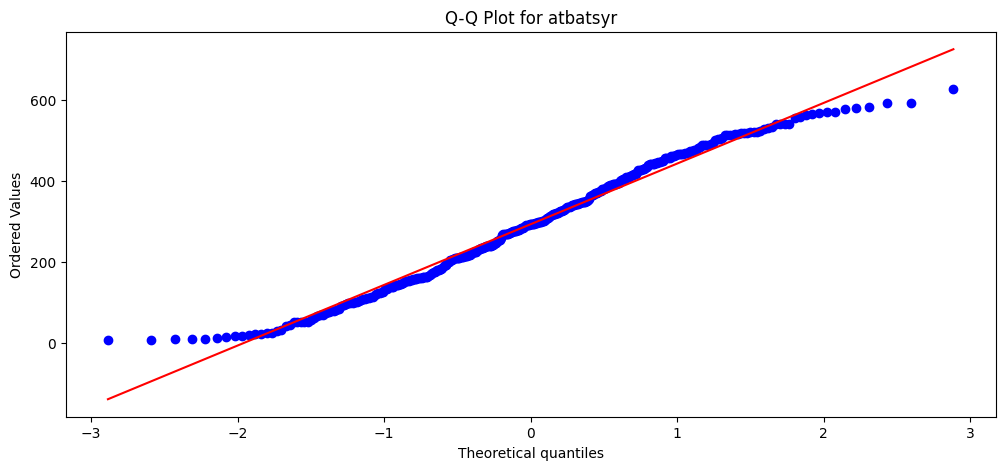

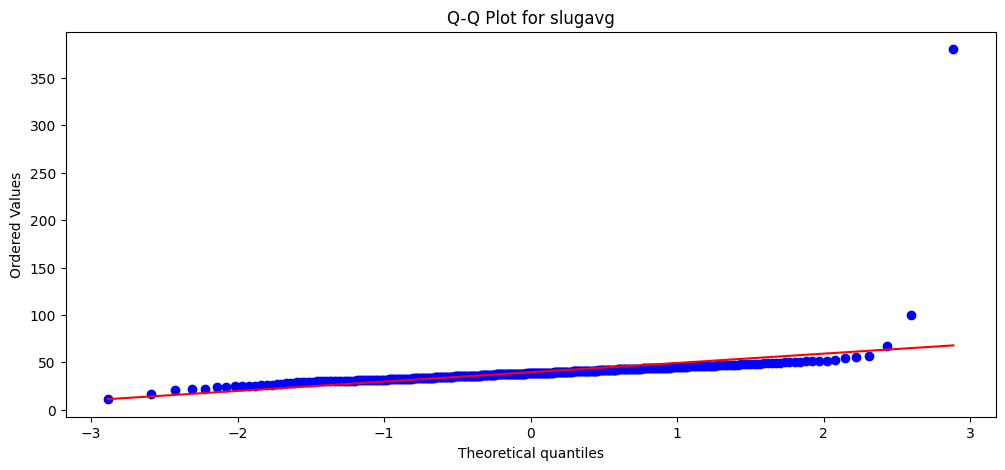

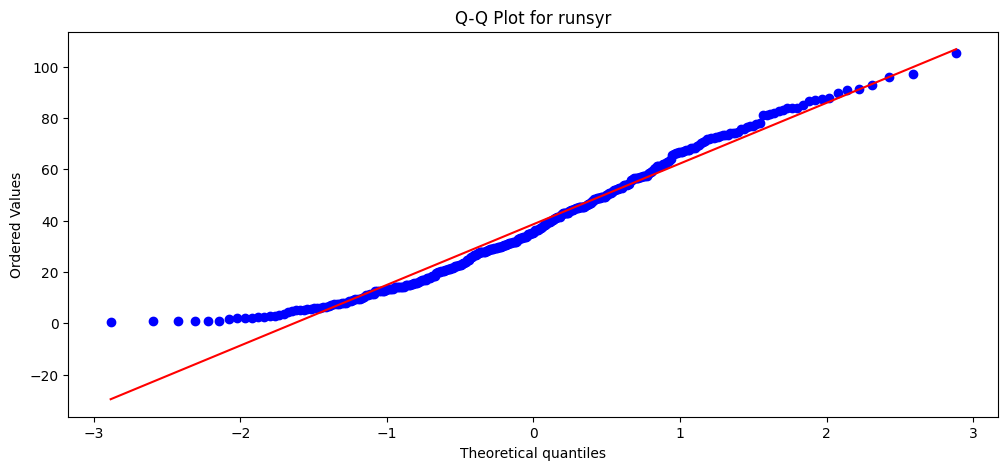

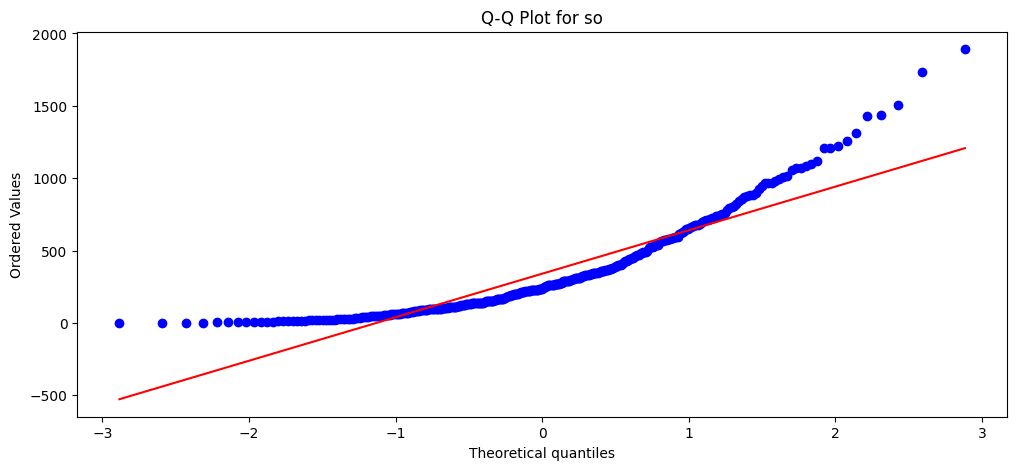

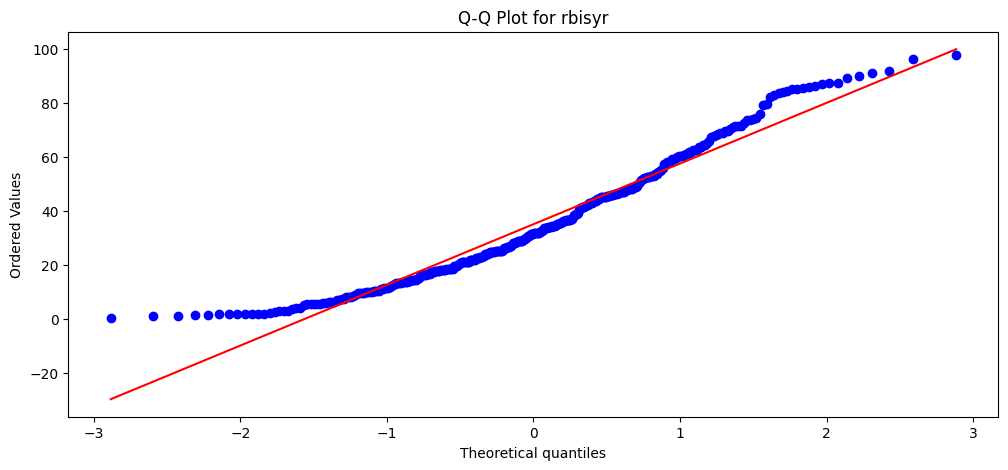

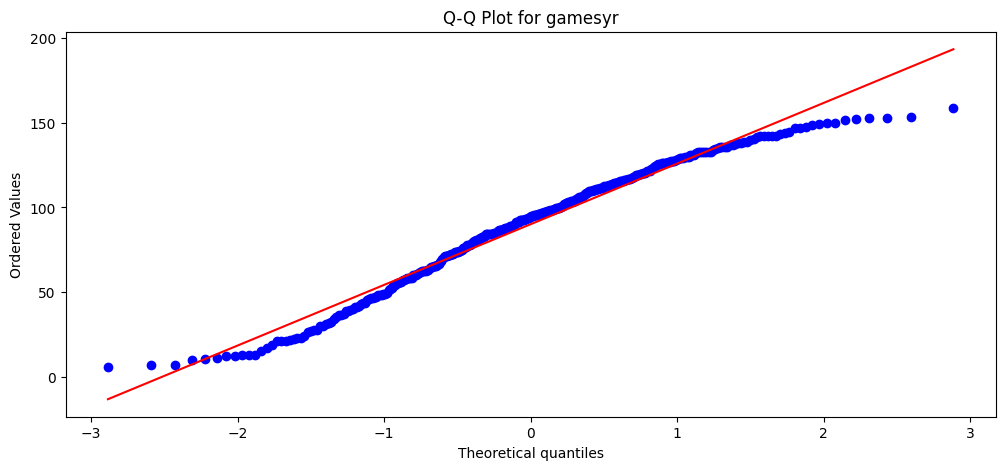

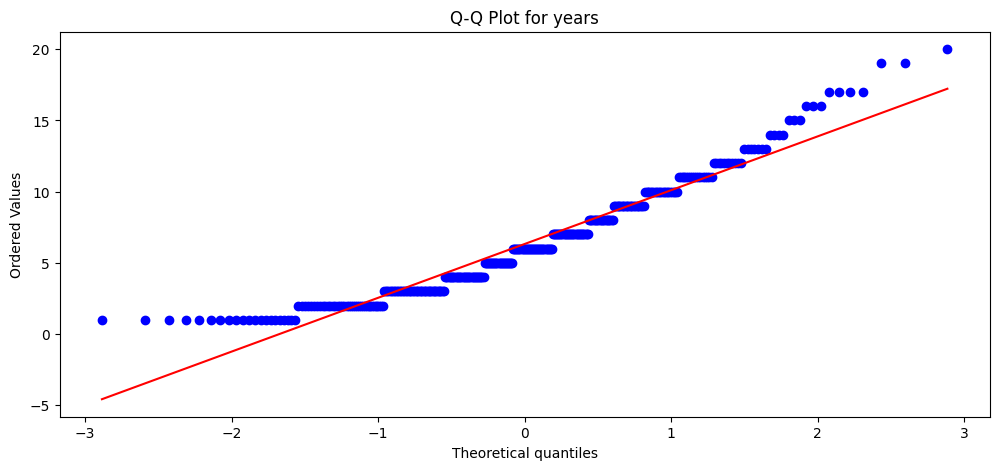

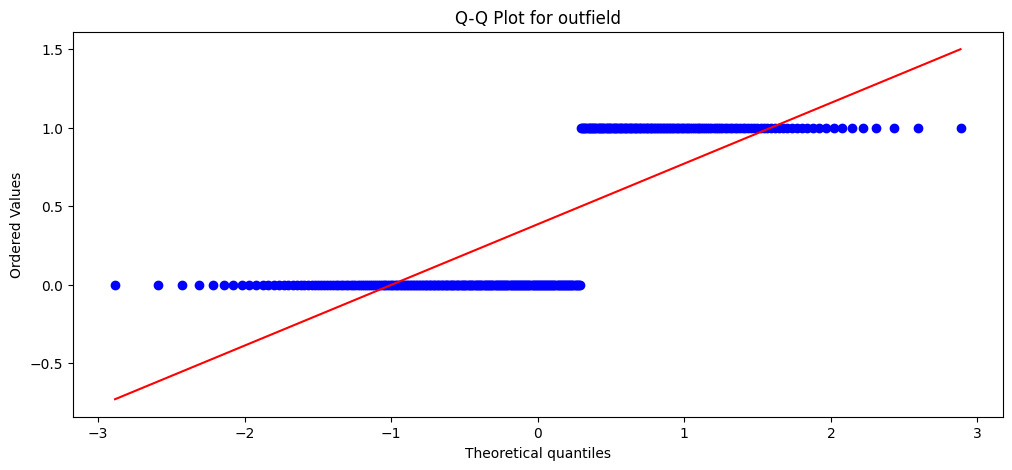

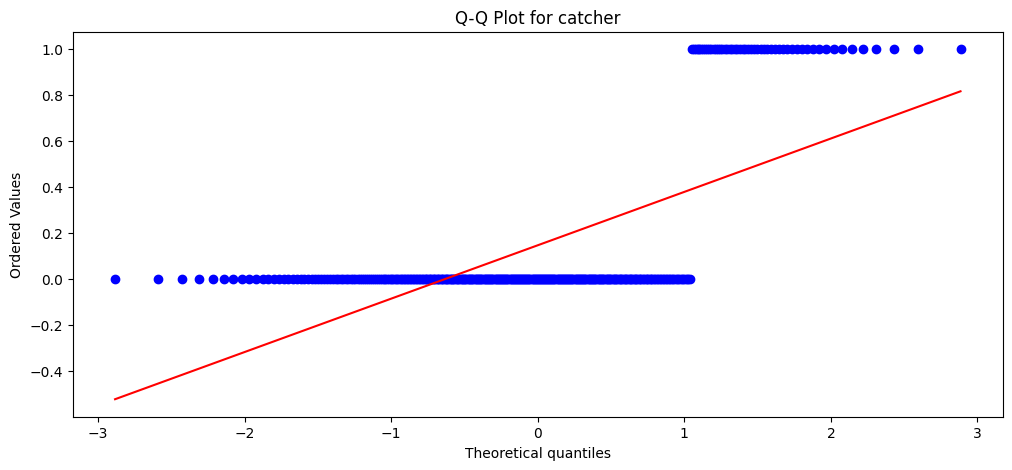

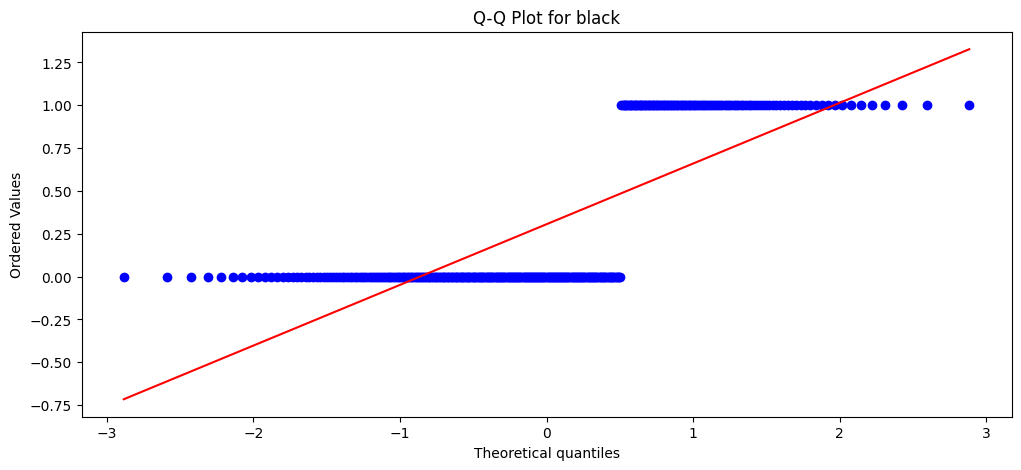

In [65]:
# quantile plots
for column in data.columns[:]:
    plt.figure(figsize = (12, 5))
    stats.probplot(data[column],dist = 'norm',plot = plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.show()


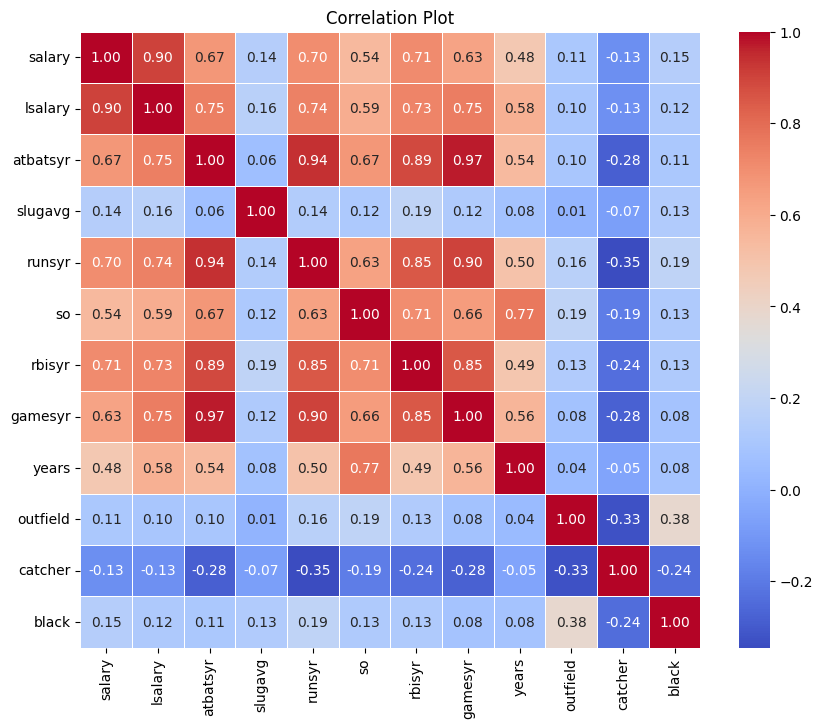

In [48]:
# correlation plot for data
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()
# there exists some correlation between predictors, which we should deal with later

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,2.644768,291.577467,307.043340,inf,0.045345,0.449235
bradford,2.820582,289.707489,301.306893,inf,0.053765,0.250200
reciprocal,2.822344,289.013039,304.478911,inf,0.042895,0.520537
loguniform,2.822344,289.013039,304.478911,inf,0.042895,0.520537
johnsonsb,2.836343,292.623379,308.089252,inf,0.045876,0.434478


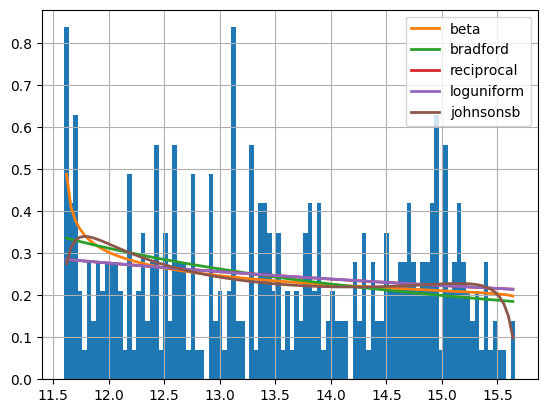

In [67]:
# 2.b
# use python Fitter to estimate distribution
# Fit various distributions for lsalary:
from fitter import Fitter
f = Fitter(data.lsalary)
f.fit()
f.summary()
# the best fitted distribution is bradford

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000076,1312.813565,1336.012373,inf,0.042097,0.544749
tukeylambda,0.000078,1315.956355,1327.555759,inf,0.043566,0.500512
anglit,0.000079,1318.369545,1326.102481,inf,0.035574,0.749099
genhalflogistic,0.000079,1307.854774,1319.454178,inf,0.048409,0.367968
johnsonsb,0.000079,1318.333568,1333.799440,inf,0.030769,0.881445


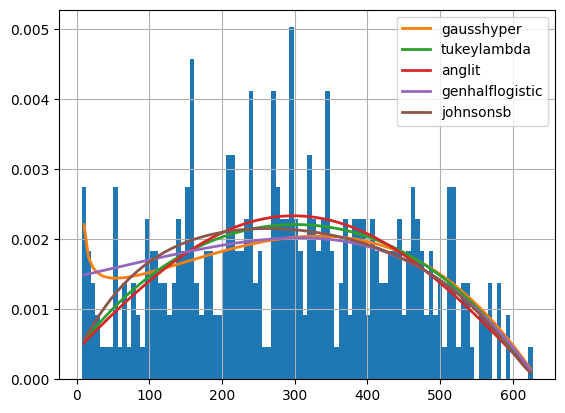

In [68]:
# use python Fitter to estimate distribution
# Fit various distributions for atbatsyr:
f = Fitter(data.atbatsyr)
f.fit()
f.summary()
# the best fitted distribution is genhalflogistic

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
tukeylambda,0.000289,5279.560161,5291.159565,inf,0.029100,0.917406
mielke,0.000305,3555.746868,3571.212740,inf,0.033488,0.810658
burr,0.000305,3557.066885,3572.532757,inf,0.033510,0.810050
hypsecant,0.000344,6334.447160,6342.180096,inf,0.058604,0.170056
fisk,0.000347,3384.853419,3396.452823,inf,0.040126,0.606058


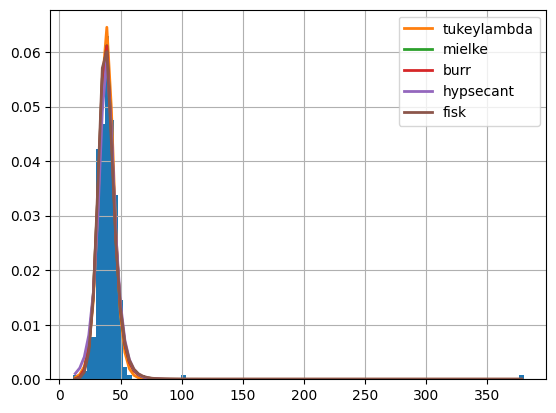

In [69]:
# use python Fitter to estimate distribution
# Fit various distributions for slugavg:
f = Fitter(data.slugavg)
f.fit()
f.summary()
# the best fitted distribution is fisk

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhalflogistic,0.002329,991.164538,1002.763942,inf,0.024240,0.982502
gausshyper,0.002354,995.851041,1019.049849,inf,0.034201,0.790170
beta,0.002423,987.482790,1002.948662,inf,0.040143,0.605505
mielke,0.002430,1007.504261,1022.970133,inf,0.034949,0.768024
kappa3,0.002445,997.153948,1008.753352,inf,0.042724,0.525700


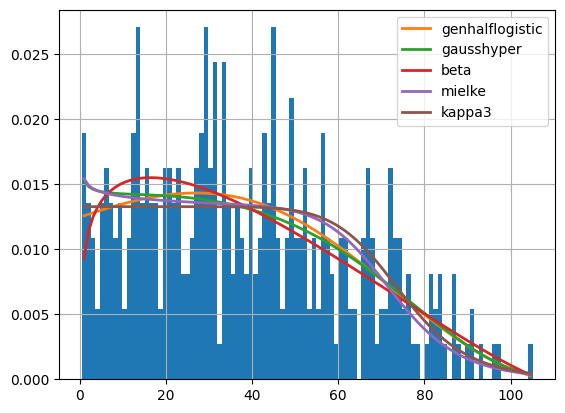

In [70]:
# use python Fitter to estimate distribution
# Fit various distributions for score:
f = Fitter(data.runsyr)
f.fit()
f.summary()
# the best fitted distribution is beta

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
geninvgauss,0.000005,1727.742982,1743.208854,inf,0.030556,8.863734e-01
genhyperbolic,0.000005,1729.502757,1748.835097,inf,1.000000,0.000000e+00
gengamma,0.000005,1729.341647,1744.807520,inf,0.390935,4.151492e-49
expon,0.000005,1725.538909,1733.271846,inf,0.028359,9.312390e-01
pareto,0.000005,1727.538905,1739.138309,inf,0.028359,9.312388e-01


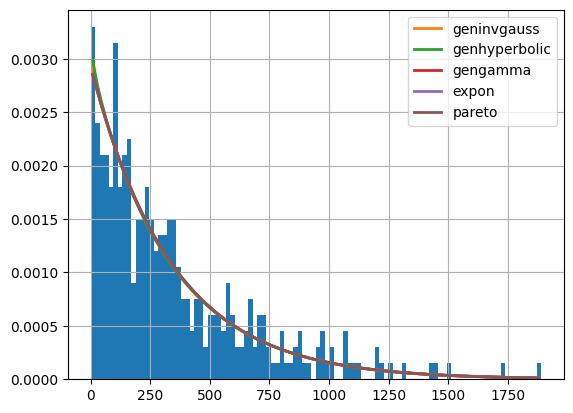

In [71]:
# use python Fitter to estimate distribution
# Fit various distributions for score:
f = Fitter(data.so)
f.fit()
f.summary()
# the best fitted distribution is expon

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gengamma,0.003706,975.681804,991.147676,inf,0.023977,0.984381
chi,0.003733,979.052402,990.651807,inf,0.034962,0.767642
genhalflogistic,0.003747,972.472270,984.071675,inf,0.035294,0.757639
foldnorm,0.003754,976.556524,988.155928,inf,0.031242,0.870124
ncf,0.003759,988.690704,1008.023045,inf,0.043079,0.515012


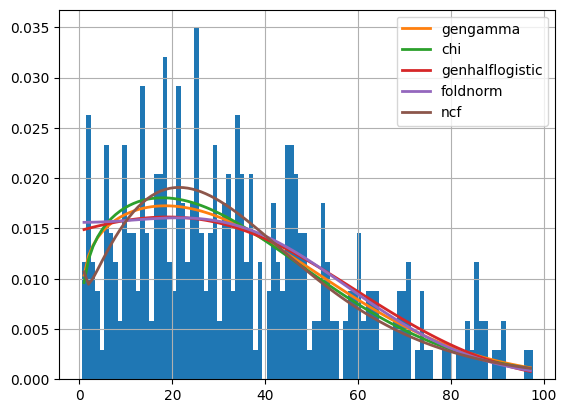

In [72]:
# use python Fitter to estimate distribution
# Fit various distributions for rbisyr:
f = Fitter(data.rbisyr)
f.fit()
f.summary()
# the best fitted distribution is genhalflogistic

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED johnsonsu distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000850,1039.637912,1062.836720,inf,0.035283,0.757957
genextreme,0.000858,1056.427987,1068.027391,inf,0.026044,0.965325
triang,0.000869,1047.126506,1058.725910,inf,0.027606,0.943854
genhyperbolic,0.000874,1066.934228,1086.266568,inf,0.033352,0.814498
pearson3,0.000875,1063.028790,1074.628194,inf,0.033543,0.809120


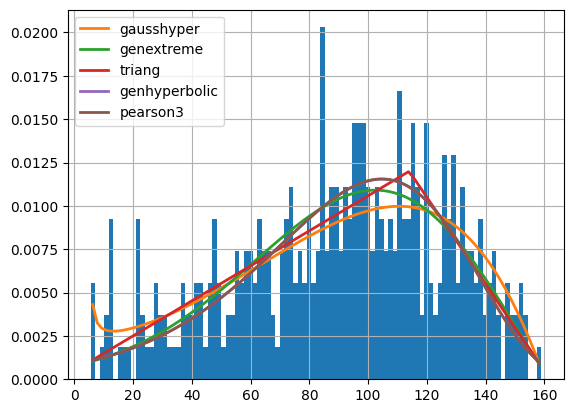

In [73]:
# 2.b
# use python Fitter to estimate distribution
# Fit various distributions for gamesyr:
f = Fitter(data.gamesyr)
f.fit()
f.summary()
# the best fitted distribution is triang:

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
SKIPPED johnsonsu distribution (taking more than 30 seconds)
SKIPPED kappa4 distribution (taking more than 30 seconds)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
SKIPPED powerlognorm distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)
SKIPPED triang distribution (taking more than 30 seconds)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
foldnorm,1.832979,711.650639,723.250043,inf,0.066416,0.084879
gompertz,1.833204,709.767330,721.366734,inf,0.069774,0.061294
genhalflogistic,1.833643,709.308443,720.907847,inf,0.071364,0.052241
truncnorm,1.834125,702.875082,718.340954,inf,0.078954,0.023192
skewnorm,1.834456,705.556884,717.156288,inf,0.084828,0.011694


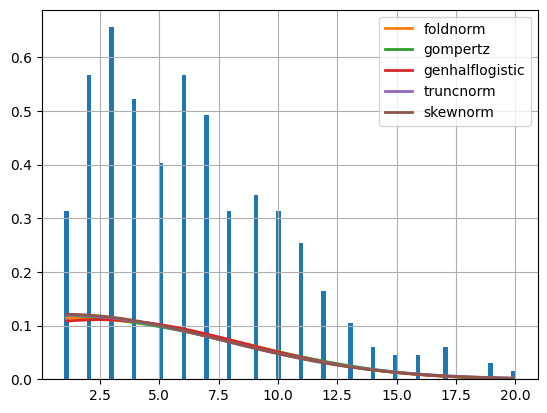

In [74]:
# 2.b
# use python Fitter to estimate distribution
# Fit various distributions for years:
from fitter import Fitter
f = Fitter(data.years)
f.fit()
f.summary()
# the best fitted distribution is skewnorm

In [77]:
# 2.c
from simple_colors import *
for col in data.iloc[:,1:-3]:
    ols_mod = smf.ols(formula='lsalary ~ '+col, data=data)
    ols_fit = ols_mod.fit()
    name = ["t-stat", "p-value"]
    test = sms.linear_harvey_collier(ols_fit)
    print(blue(col+ " Linearity Test Results:",['bold']))
    print(list(zip(name, test)))
    print("\n")
#There's no non-linearities within the variables,we would perform  Box-Cox scale power transformation to make them linear
#Including non-linear variables in linear regression would result in Biased Parameter Estimates

atbatsyr Linearity Test Results:
[('t-stat', -0.7020362613333653), ('p-value', 0.4831244713938133)]


slugavg Linearity Test Results:
[('t-stat', 0.06155902188244617), ('p-value', 0.9509492486841383)]


runsyr Linearity Test Results:
[('t-stat', -0.9037315788395567), ('p-value', 0.3667611183671061)]


so Linearity Test Results:
[('t-stat', 0.028837737497420735), ('p-value', 0.977010486359087)]


rbisyr Linearity Test Results:
[('t-stat', -1.0388292051170434), ('p-value', 0.29960334543446043)]


gamesyr Linearity Test Results:
[('t-stat', -0.7749839011148099), ('p-value', 0.43887392672655223)]


years Linearity Test Results:
[('t-stat', -0.8866778305809311), ('p-value', 0.37586296020428045)]




In [79]:
# if using Box-cox scale power transformation, the lambda would be:
bc_data = pd.DataFrame()
bc_lambda = {}
data['so'] = data['so']+0.001
for col in data.iloc[:,1:-3]:
    bc_data[col] = stats.boxcox(data[col])[0]
    bc_lambda[col] = stats.boxcox(data[col])[1]
bc_lambda

{'atbatsyr': 0.799731503298007,
 'slugavg': -0.3787477265851271,
 'runsyr': 0.58033539921631,
 'so': 0.3071935998721373,
 'rbisyr': 0.5028063965189329,
 'gamesyr': 1.1688916813810224,
 'years': 0.342885169907899}

In [80]:
#the transformed data would be
bc_data

,atbatsyr,slugavg,runsyr,so,rbisyr,gamesyr,years
0,195.579994,2.021133,21.692272,23.477524,14.810184,279.891719,3.920902
1,154.399415,1.983742,15.129418,19.756742,11.152644,217.846875,3.033442
2,196.326207,1.995771,19.222915,14.000358,14.971081,298.727443,2.147852
3,154.548786,1.983822,15.081308,20.585004,12.600166,256.745142,3.033442
4,118.527568,1.971159,12.157154,21.363448,11.508529,184.631760,3.920902
...,...,...,...,...,...,...,...
348,92.017642,1.916809,10.680428,11.533967,6.178441,159.085678,2.147852
349,134.152228,1.958703,11.036650,10.728427,9.371684,197.383308,0.782450
350,110.726286,1.993071,12.358858,14.795238,10.176521,148.912875,1.334161
351,133.481474,1.922851,12.101775,14.251937,8.633976,209.885176,2.474553


In [5]:
# 2.d
ols_mod = smf.ols(formula='lsalary ~ atbatsyr+slugavg+runsyr+so+rbisyr+gamesyr+years+catcher+black+outfield', data=data)
ols_fit = ols_mod.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     64.62
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.10e-72
Time:                        16:02:43   Log-Likelihood:                -372.26
No. Observations:                 353   AIC:                             766.5
Df Residuals:                     342   BIC:                             809.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2621      0.156     72.144      0.0

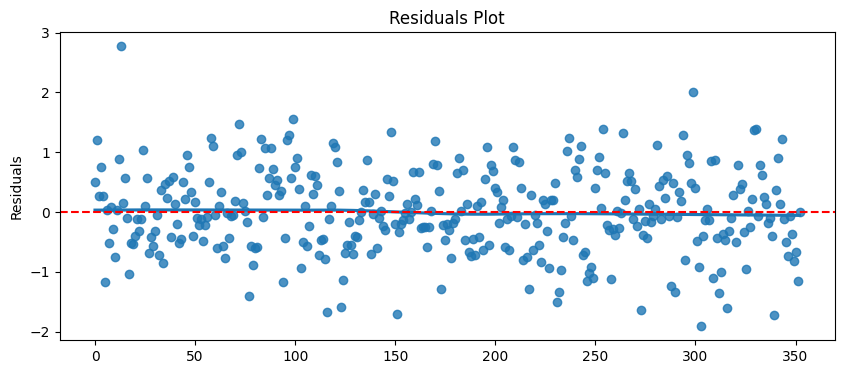

In [6]:
# Residuals Plot 
plt.figure(figsize = (10, 4))
sns.regplot(x = data.index, y = ols_fit.resid,lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

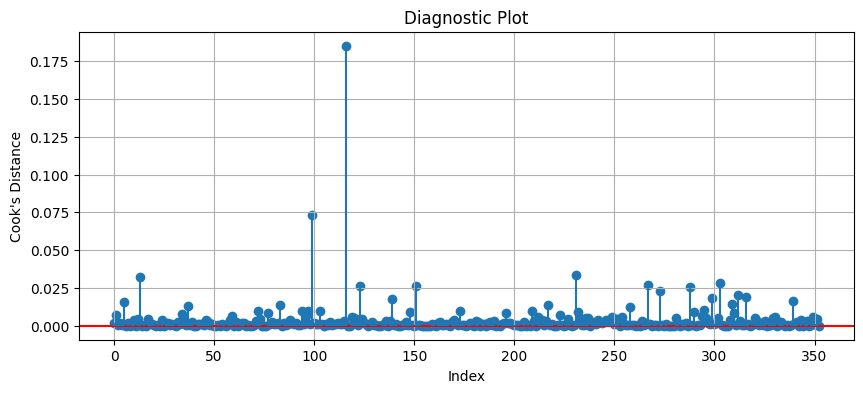

In [13]:
# Cook’s distance Plot for the new model
cooks_distance = ols_fit.get_influence().cooks_distance[0]
plt.figure(figsize = (10, 4))
plt.scatter(data.index, cooks_distance)
plt.axhline(0, color = 'red')
plt.vlines(x = data.index, ymin = 0, ymax = cooks_distance)
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()
# There seems to be more than two influencials, we decide to remove them

In [14]:
# remove outliers base on cooks_distance
thresh = 4/len(ols_fit.fittedvalues)
data_new = data[cooks_distance < thresh]
data_new

,lsalary,atbatsyr,slugavg,runsyr,so,rbisyr,gamesyr,years,outfield,catcher,black
0,15.660686,558.750000,46.025352,89.666664,948,69.666664,142.083328,12,0,0,0
1,15.031906,416.625000,39.423943,50.875000,582,42.750000,114.750000,8,0,0,1
2,14.946913,561.400024,41.396507,74.000000,228,71.000000,150.199997,5,0,0,0
3,14.880221,417.125000,39.436619,50.625000,653,52.625000,132.000000,8,0,0,0
4,14.316286,300.250000,37.496532,36.416668,725,45.083332,99.666664,12,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
348,12.650759,219.600006,30.510017,30.000000,138,16.600000,87.800003,5,0,0,0
349,12.524527,350.000000,35.714287,31.500000,115,32.000000,105.500000,2,0,1,0
350,12.429216,276.000000,40.942028,37.333332,264,36.666668,83.000000,3,0,0,0
351,12.206073,347.833344,31.193100,36.166668,239,28.000000,111.166664,6,0,0,0


In [16]:
# 2,e 
# Check if there are any missing observations
print(data_new.isnull().any())
# There are no NAs in our data

lsalary     False
atbatsyr    False
slugavg     False
runsyr      False
so          False
rbisyr      False
gamesyr     False
years       False
outfield    False
catcher     False
black       False
dtype: bool


In [21]:
# 3. run the original multilinear regression
ols_mod1 = smf.ols(formula='lsalary ~ atbatsyr+slugavg+runsyr+so+rbisyr+gamesyr+years+catcher+black+outfield', data=data_new)
ols_fit1 = ols_mod1.fit()
print(ols_fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     96.14
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           2.69e-90
Time:                        16:11:56   Log-Likelihood:                -300.25
No. Observations:                 332   AIC:                             622.5
Df Residuals:                     321   BIC:                             664.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8563      0.251     43.206      0.0

In [75]:
# Use the Mallows Cp methods in Model Selection
from RegscorePy import mallow
import itertools
model = smf.ols(formula='lsalary ~ atbatsyr+slugavg+runsyr+so+rbisyr+gamesyr+years+catcher+black+outfield', data=data_new)
results = model.fit()
y = data_new.lsalary
y_pred=results.fittedvalues
subdat = data_new.iloc[:,1:].copy()
storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 10 # number of parameters in orginal model (includes y-intercept)

for L in range(1, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        # join the strings in the data together
        formula1 = 'lsalary~'+'+'.join(subset)
        
        # get the cp
        results = smf.ols(formula=formula1, data = data_new).fit()
        y_sub = results.fittedvalues
        p = len(subset)+1 # number of parameters in the subset model (includes y-intercept)
        
        cp = mallow.mallow(y, y_pred,y_sub, k, p)
        
        # add to the dataframe
        storage_cp = storage_cp._append({'Variables': subset, 'CP': cp}, ignore_index = True)
storage_cp = storage_cp.sort_values(by = "CP").reset_index()
storage_cp.sort_values(by = "CP").reset_index()['Variables'][0]

('runsyr', 'so', 'rbisyr', 'gamesyr', 'years', 'outfield', 'catcher')

In [132]:
# run the Mallows CP methods selected model
ols_mod2 = smf.ols(formula='lsalary ~ runsyr+so+rbisyr+gamesyr+years+outfield+catcher', data=data_new)
ols_fit2 = ols_mod2.fit()
print(ols_fit2.summary())
# the AIC and BIC values decrease

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           4.77e-93
Time:                        17:13:03   Log-Likelihood:                -301.24
No. Observations:                 332   AIC:                             618.5
Df Residuals:                     324   BIC:                             648.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1203      0.124     89.442      0.0

In [96]:
# Test for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# Get the design matrix (set of predictors + intercept)

X = data_new[['runsyr', 'so', 'rbisyr', 'gamesyr', 'years', 'outfield', 'catcher']].copy()
  
# Create place to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)
# The result shows multicollinearity between atbatsyr,runsyr,gamesyr and rbisyr

    feature        VIF
0    runsyr  30.099517
1        so   9.424014
2    rbisyr  18.961034
3   gamesyr  29.216071
4     years  10.835548
5  outfield   1.628919
6   catcher   1.421734


In [97]:
# Deal with multicollinearity by removing predictors
X = data_new[['so', 'rbisyr', 'years', 'outfield', 'catcher']].copy()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)
# The result shows no multicollinearity now

    feature       VIF
0        so  8.217220
1    rbisyr  5.927180
2     years  6.872380
3  outfield  1.553730
4   catcher  1.236965


In [116]:
# run the model without multicollinearity
ols_mod3 = smf.ols(formula='lsalary ~ so+rbisyr+years+outfield+catcher', data=data_new)
ols_fit3 = ols_mod3.fit()
print(ols_fit3.summary())
# the AIC and BIC values increase

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     157.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.31e-84
Time:                        17:08:42   Log-Likelihood:                -326.48
No. Observations:                 332   AIC:                             665.0
Df Residuals:                     326   BIC:                             687.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5043      0.097    118.922      0.0

In [117]:
# Model Misspecification
import statsmodels.stats.outliers_influence as smo
reset_out = smo.reset_ramsey(res = ols_fit3, degree = 2)
reset_out
# The result suggests including higher order terms

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=55.07669084066301, p=1.022286820385567e-12, df_denom=325, df_num=1>

In [136]:
# run the model with higher order
ols_mod4 = smf.ols(formula='lsalary ~ so+rbisyr+years+outfield+catcher+I(so**2)+I(rbisyr**2)+I(years**2)', data=data_new)
ols_fit4 = ols_mod4.fit()
print(ols_fit4.summary())
# the square of variables rbisyr and years are significant while so is not, so we only include the higher order of rbisyr and years

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     142.1
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          5.72e-101
Time:                        17:14:25   Log-Likelihood:                -279.80
No. Observations:                 332   AIC:                             577.6
Df Residuals:                     323   BIC:                             611.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.8043      0.128     84.

In [140]:
# run the model with interaction
ols_mod5 = smf.ols(formula='lsalary ~ rbisyr+years+so*(outfield+catcher)+I(rbisyr**2)+I(years**2)', data=data_new)
ols_fit5 = ols_mod5.fit()
print(ols_fit5.summary())
# the interaciton between so and catcher are significant while so and outfield is not, so we only include the interaction of so and catcher

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     126.4
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          4.23e-100
Time:                        17:18:24   Log-Likelihood:                -279.28
No. Observations:                 332   AIC:                             578.6
Df Residuals:                     322   BIC:                             616.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.7591      0.124     86.

In [142]:
# The model without misspecification 
ols_mod6 = smf.ols(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_new)
ols_fit6 = ols_mod6.fit()
print(ols_fit6.summary())


                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     142.6
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          3.45e-101
Time:                        17:19:33   Log-Likelihood:                -279.28
No. Observations:                 332   AIC:                             576.6
Df Residuals:                     323   BIC:                             610.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.7626      0.120     89.

In [144]:
# Test Model Misspecification agagin
import statsmodels.stats.outliers_influence as smo
reset_out = smo.reset_ramsey(res = ols_fit6, degree = 2)
reset_out
# There are no model misspecification now

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.4662219499796919, p=0.495221343851706, df_denom=322, df_num=1>

In [145]:
# Heteroskedasticity: Breush-Pagan --> Ho: var = constant
import statsmodels.stats.api as sms
from simple_colors import *
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(ols_fit6.resid, ols_fit6.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))
# reject Ho, there is heteroskedasticity in our model

BP Results:
[('Lagrange multiplier statistic', 48.968116299300334), ('p-value', 6.447880110000809e-08), ('f-value', 6.9853886061648796), ('f p-value', 1.67266252662479e-08)]


In [148]:
# Test for Heteroskedasticity with spread plot
def spread_level(model, data):
    df_copy = data.copy()
    
    # Get the studentized residuals
    df_copy["Absolute_Studentized_Residuals"] = (np.abs(model.get_influence().resid_studentized))
    df_copy["Fitted_Values"] = (model.fittedvalues)
    
    # run regression to get slope of fitted vs resid, rlm is a robust linear model used by R
    slreg = smf.rlm("np.log(Absolute_Studentized_Residuals) ~ np.log(Fitted_Values)", df_copy).fit()
    slope = slreg.params[1]
    
    # plot values
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.set_title("Fitted Values vs Studentized Residuals")
    sns.regplot(x = "Fitted_Values", y = "Absolute_Studentized_Residuals", data = df_copy, lowess = True, ax = ax)
    ax.plot(df_copy.Fitted_Values.values, np.exp(slreg.fittedvalues).values)
    
    # Set to the logarithmic scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    
    # Resolve overlapping label bug
    ax.minorticks_off()
    
    # Set tick labels automatically
    ax.set_xticks(np.linspace(df_copy["Fitted_Values"].min(),df_copy["Fitted_Values"].max(), 6))
    ax.set_yticks(np.linspace(df_copy["Absolute_Studentized_Residuals"].min(),
                              df_copy["Absolute_Studentized_Residuals"].max(), 6))
    
    ax.grid()
    
    # return a suggested power transform of your y-variable that may correct heteroscedastcity
    # The transform is just one minus the slope of the reegression line of your fitted values vs residuals
    print("Suggested Power Transformation:", 1-slope)

Suggested Power Transformation: -2.219421417220093


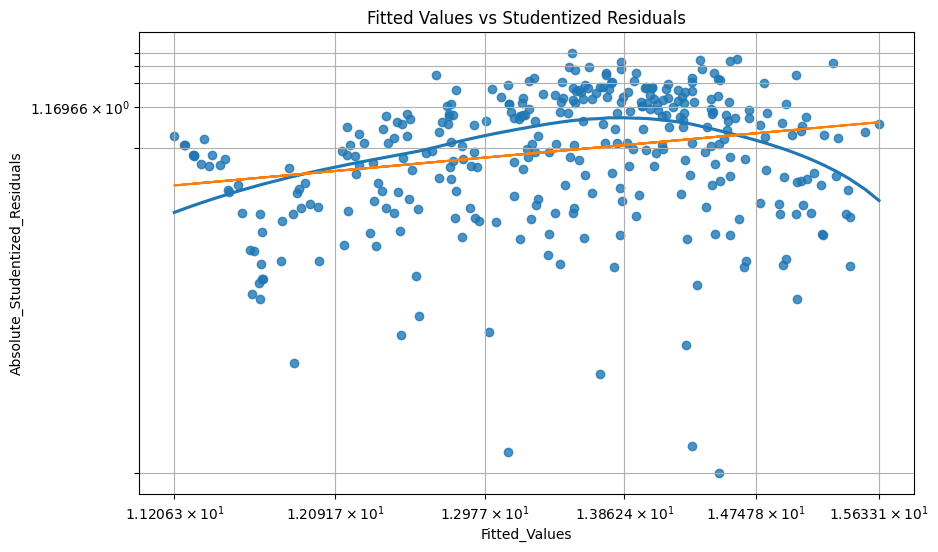

In [150]:
spread_level(ols_fit6, data_new)
# the spread plot shows unknown form of the variance

In [175]:
# estimate model:

# FGLS (estimation of the variance function):
data_new['logr2'] = np.log(ols_fit6.resid ** 2)
reg_fgls = smf.ols(formula='logr2 ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_new)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
ols_mod7 = smf.wls(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)',
                  weights=wls_weight, data=data_new)
ols_fit7 = ols_mod7.fit()
ols_fit7.summary()

FGLS (Variance Function): 
                     b      se       t    pval
Intercept      -4.4217  0.4563 -9.6902  0.0000
rbisyr          0.1050  0.0206  5.0999  0.0000
years           0.0406  0.1216  0.3341  0.7385
outfield       -0.1778  0.2654 -0.6700  0.5033
so              0.0007  0.0009  0.7533  0.4518
catcher         0.0253  0.5089  0.0498  0.9603
so:catcher     -0.0018  0.0019 -0.9546  0.3405
I(rbisyr ** 2) -0.0012  0.0002 -5.6250  0.0000
I(years ** 2)   0.0002  0.0070  0.0293  0.9767



<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.912
Model:                            WLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     419.3
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.40e-165
Time:                        17:42:57   Log-Likelihood:                -238.07
No. Observations:                 332   AIC:                             494.1
Df Residuals:                     323   BIC:                             528.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.9349      0.067    162.083      0.000      10.802      11.068
rbisyr             0.0472      0.004     12.971      0.000       0.040       0.054
years              0.3220      0.024     13.521      0.000       0.275       0.369
outfield           0.0904      0.052      1.744      0.082      -0.012       0.192
so                -0.0004      0.000     -1.671      0.096      -0.001    6.53e-05
catcher           -0.1331      0.087     -1.537      0.125      -0.303       0.037
so:catcher         0.0012      0.000      3.012      0.003       0.000       0.002
I(rbisyr ** 2)    -0.0002   3.53e-05     -4.586      0.000      -0.000   -9.24e-05
I(years ** 2)     -0.0140      0.002     -9.236      0.000      -0.017      -0.011
==============================================================================
Omnibus:                        0.282   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.365
Skew:                          -0.065   Prob(JB):                        0.833
Kurtosis:                       2.902   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

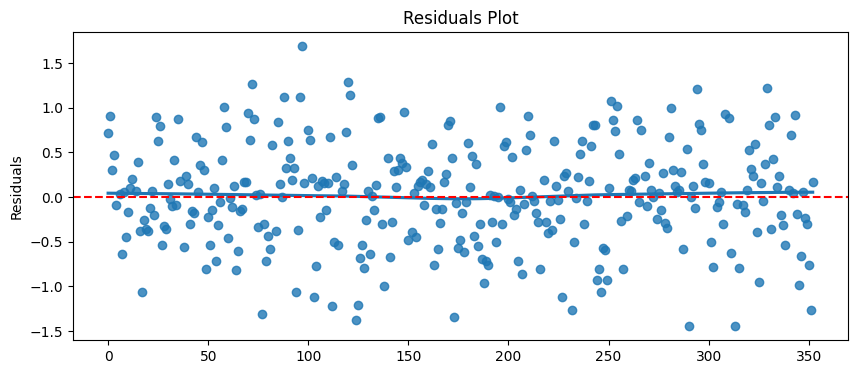

In [166]:
# Residuals Plot 
plt.figure(figsize = (10, 4))
sns.regplot(x = data_new.index, y = ols_fit7.resid,lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

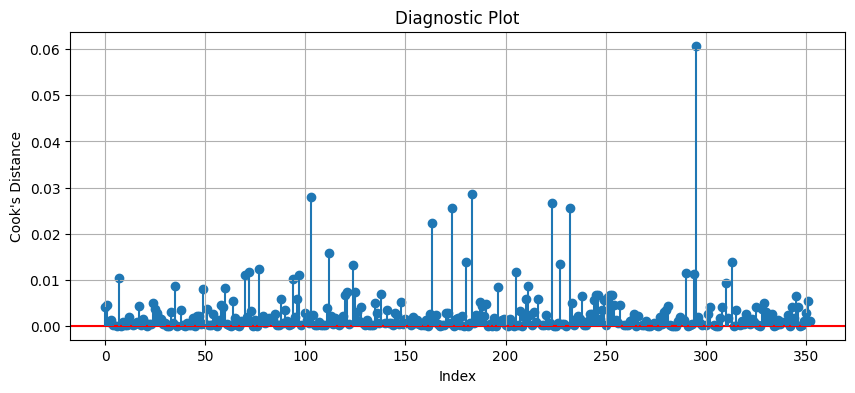

In [182]:
# Cook’s distance Plot for the new model
# wls regressio do not have get_influence function, so we use ols_fit6
cooks_distance = ols_fit6.get_influence().cooks_distance[0]
plt.figure(figsize = (10, 4))
plt.scatter(data_new.index, cooks_distance)
plt.axhline(0, color = 'red')
plt.vlines(x = data_new.index, ymin = 0, ymax = cooks_distance)
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()


In [261]:
# remove outliers base on cooks_distance
thresh = 4/len(ols_fit.fittedvalues)
data_final = data_new[cooks_distance < thresh]
data_final

,lsalary,atbatsyr,slugavg,runsyr,so,rbisyr,gamesyr,years,outfield,catcher,black,logr2
0,15.660686,558.750000,46.025352,89.666664,948,69.666664,142.083328,12,0,0,0,-0.725682
1,15.031906,416.625000,39.423943,50.875000,582,42.750000,114.750000,8,0,0,1,-0.223009
2,14.946913,561.400024,41.396507,74.000000,228,71.000000,150.199997,5,0,0,0,-2.623700
3,14.880221,417.125000,39.436619,50.625000,653,52.625000,132.000000,8,0,0,0,-1.514637
4,14.316286,300.250000,37.496532,36.416668,725,45.083332,99.666664,12,1,0,1,-3.345363
...,...,...,...,...,...,...,...,...,...,...,...,...
348,12.650759,219.600006,30.510017,30.000000,138,16.600000,87.800003,5,0,0,0,-2.822910
349,12.524527,350.000000,35.714287,31.500000,115,32.000000,105.500000,2,0,1,0,-2.684561
350,12.429216,276.000000,40.942028,37.333332,264,36.666668,83.000000,3,0,0,0,-0.727981
351,12.206073,347.833344,31.193100,36.166668,239,28.000000,111.166664,6,0,0,0,0.521453


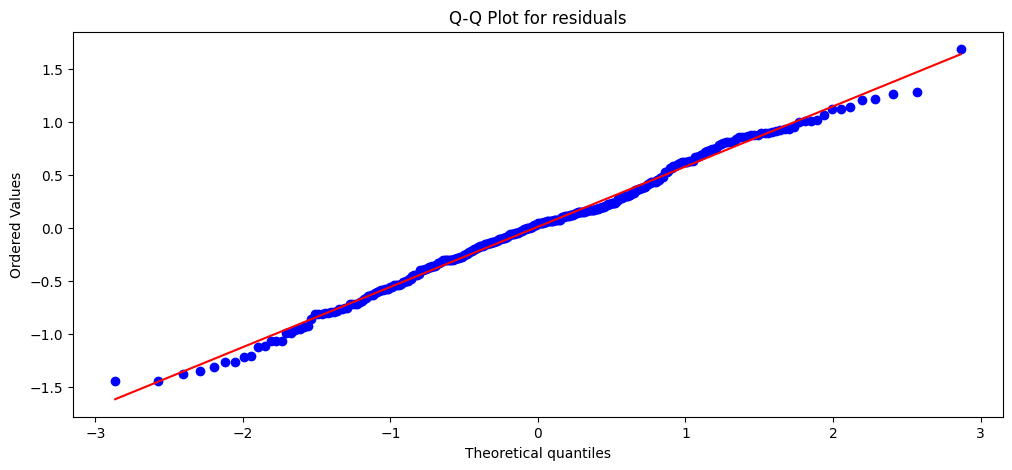

In [185]:
# quantile plots
plt.figure(figsize = (12, 5))
stats.probplot(ols_fit7.resid,dist = 'norm',plot = plt)
plt.title(f'Q-Q Plot for residuals')
plt.show()


In [227]:
reg_fgls = smf.ols(formula='logr2 ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_final)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
ols_mod8 = smf.wls(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)',
                  weights=wls_weight, data=data_final)
ols_fit8 = ols_mod8.fit()
ols_fit8.summary()

FGLS (Variance Function): 
                     b      se       t    pval
Intercept      -4.5908  0.4767 -9.6305  0.0000
rbisyr          0.1035  0.0208  4.9630  0.0000
years           0.1606  0.1430  1.1232  0.2622
outfield       -0.2364  0.2726 -0.8673  0.3864
so              0.0003  0.0011  0.3166  0.7518
catcher        -0.0794  0.5225 -0.1520  0.8793
so:catcher     -0.0021  0.0021 -1.0147  0.3110
I(rbisyr ** 2) -0.0012  0.0002 -5.5457  0.0000
I(years ** 2)  -0.0095  0.0093 -1.0242  0.3066



<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lsalary   R-squared:                       0.935
Model:                            WLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     549.5
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          5.95e-177
Time:                        23:44:35   Log-Likelihood:                -195.93
No. Observations:                 316   AIC:                             409.9
Df Residuals:                     307   BIC:                             443.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.9047      0.061    178.794      0.000      10.785      11.025
rbisyr             0.0478      0.003     13.955      0.000       0.041       0.055
years              0.3344      0.022     14.966      0.000       0.290       0.378
outfield           0.0925      0.049      1.886      0.060      -0.004       0.189
so                -0.0001      0.000     -0.712      0.477      -0.001       0.000
catcher           -0.1385      0.081     -1.708      0.089      -0.298       0.021
so:catcher         0.0011      0.000      3.071      0.002       0.000       0.002
I(rbisyr ** 2)    -0.0002   3.26e-05     -5.673      0.000      -0.000      -0.000
I(years ** 2)     -0.0152      0.001    -10.878      0.000      -0.018      -0.012
==============================================================================
Omnibus:                        5.118   Durbin-Watson:                   1.420
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                3.360
Skew:                           0.057   Prob(JB):                        0.186
Kurtosis:                       2.508   Cond. No.                     1.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
# Based on AIC and BIC, the Least

# Assume you have models stored in a list
models = [ols_fit1, ols_fit2,ols_fit3, ols_fit4, ols_fit5, ols_fit6, ols_fit7,ols_fit8]
aic_bic = pd.DataFrame()
aic_bic['models'] = ['ols_fit1','ols_fit2','ols_fit3','ols_fit4', 'ols_fit5','ols_fit6', 'ols_fit7','ols_fit8']
# Get AIC and BIC for each model
aic_bic['aic_values'] = [model.aic for model in models]
aic_bic['bic_values'] = [model.bic for model in models]

aic_bic
# Find the model with the minimum AIC and BIC
# The best model is ols_fit8

,models,aic_values,bic_values
0,ols_fit1,622.498503,664.354988
1,ols_fit2,618.484683,648.925762
2,ols_fit3,664.965730,687.796540
3,ols_fit4,578.553100,616.604450
4,ols_fit5,578.553100,616.604450
5,ols_fit6,576.564371,610.810586
6,ols_fit7,494.144777,528.390991
7,ols_fit8,409.865466,443.667146


In [230]:
# Evalueate the robustness of estimates by bootsrapping my model
# build dataframe to store sample statistics
coefs = pd.DataFrame(columns = ["Intercept","rbisyr","years","outfield","so","catcher","so:catcher","rbisyr ** 2","years ** 2)"])

# we will generate 1000 bootstrap samples
for i in range(1000):
    
    # sample from the data with replacement 1000 times
    sample = data_final.sample(data_final.shape[0] ,replace = True)
    
    # fit model on bootstrap sample
    reg_fgls = smf.ols(formula='logr2 ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=sample)
    results_fgls = reg_fgls.fit()
    table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                               'se': round(results_fgls.bse, 4),
                               't': round(results_fgls.tvalues, 4),
                               'pval': round(results_fgls.pvalues, 4)})

    # FGLS (WLS):
    wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
    bootstapped_mod = smf.wls(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)',
                      weights=wls_weight, data=sample)
    bootstapped_fit = bootstapped_mod.fit()

    # pull out the bootstrap sample statistics
    Intercept,rbisyr,years,outfield,so,catcher,socatcher,rbisyr2,years2 = bootstapped_fit.params
    temp = pd.DataFrame({"Intercept":Intercept, "rbisyr":rbisyr,"years":years,"outfield":outfield,"so":so,"catcher":catcher,"so:catcher":socatcher,"rbisyr ** 2":rbisyr2,"years ** 2":years2},index=[0])
    # store the bootstrap sample statistics for later use
    coefs = pd.concat([coefs,temp])

# below I calculate the percentile bootstraps for a 95% confidence interval

# # the 97.5 percentile of thebootstrap sample statistics
# b0_u, b1_u = coefs.quantile(.975)

# # the 2.5 percentile of the bootstrap sample statistics
# b0_l, b1_l = coefs.quantile(.025)

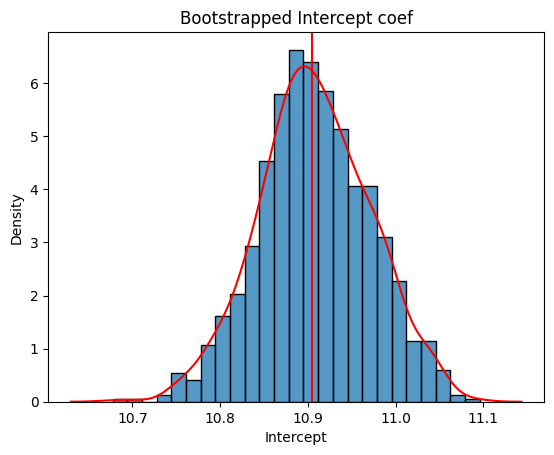

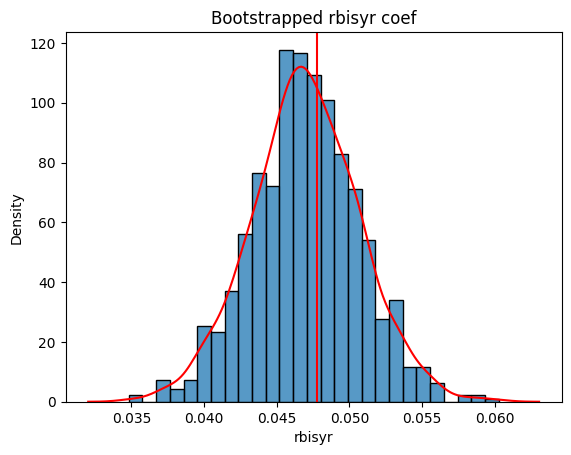

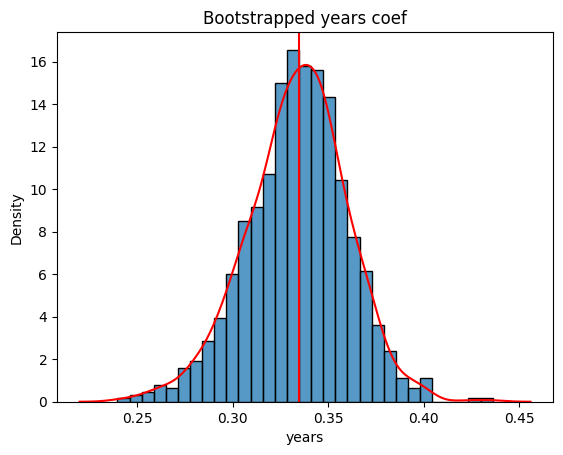

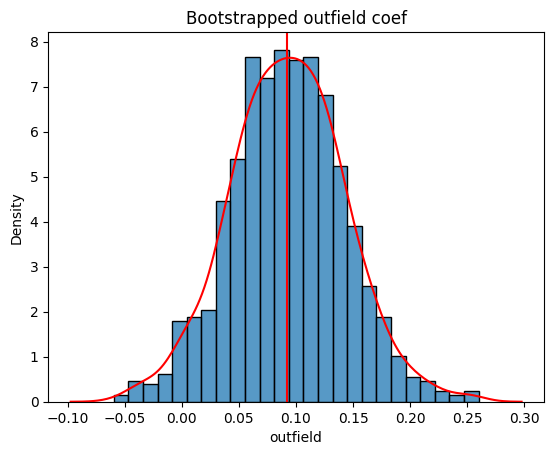

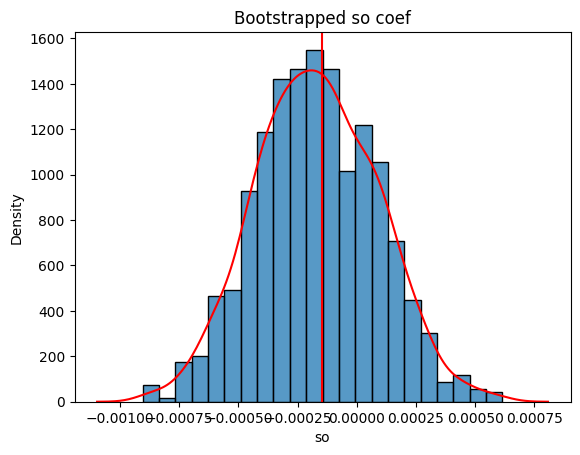

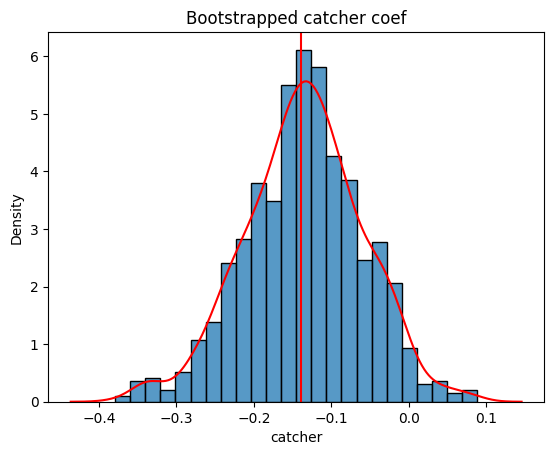

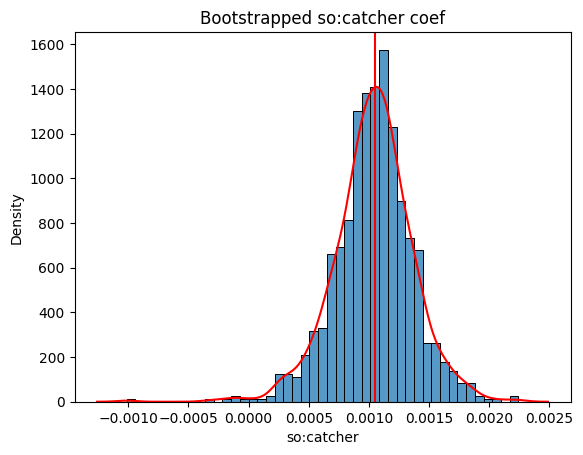

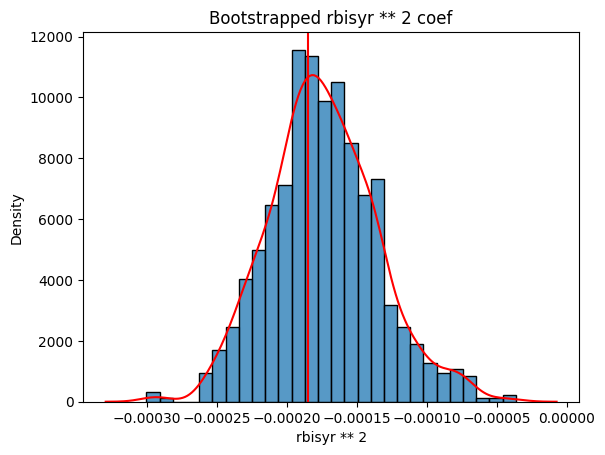

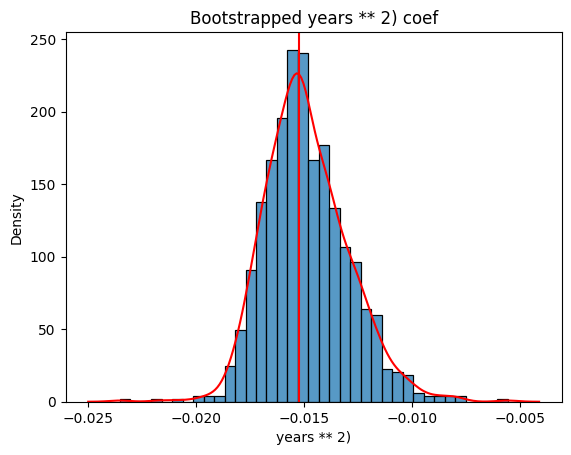

In [237]:
# histplota for Bootstrapped coefs
for i in range(len(coefs.columns)):
    column = coefs.columns
    sns.histplot(coefs[column[i]],stat = 'density')
    sns.kdeplot(coefs[column[i]],color = 'red')
    plt.axvline(ols_fit8.params[i], color = "red")
    plt.title('Bootstrapped '+column[i] + ' coef')
    plt.show()

In [255]:
# Use Cross-validation to evaluate your models performance
from sklearn.model_selection import KFold # import KFold
# split the data into 5 subsets
kf = KFold(n_splits = 5)

mse = []
for train_index, test_index in kf.split(data_final):
    # train data over training set
    reg_fgls = smf.ols(formula='logr2 ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_final.iloc[train_index])
    results_fgls = reg_fgls.fit()
    table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                               'se': round(results_fgls.bse, 4),
                               't': round(results_fgls.tvalues, 4),
                               'pval': round(results_fgls.pvalues, 4)})
    
    wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
    CV_mod = smf.wls(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)',
                      weights=wls_weight, data=data_final.iloc[train_index])
    CV_fit = bootstapped_mod.fit()
    
    # test over last split 
    s = ((data_final.iloc[test_index]["lsalary"] - CV_fit.predict(data_final.iloc[test_index]))**2).mean()
    # append test metric
    mse.append(s)
# mse for final model
mse

[0.2086130625179908,
 0.3742648076117743,
 0.21971356399227981,
 0.25165628668848444,
 0.29503001629341485]

In [254]:
mse2 = []
for train_index, test_index in kf.split(data_final):
    # train data over training set
    reg_fgls = smf.ols(formula='logr2 ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_final.iloc[train_index])
    results_fgls = reg_fgls.fit()
    table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                               'se': round(results_fgls.bse, 4),
                               't': round(results_fgls.tvalues, 4),
                               'pval': round(results_fgls.pvalues, 4)})
    
    wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
    CV_mod = smf.ols(formula='lsalary ~ rbisyr+years+outfield+so*catcher+I(rbisyr**2)+I(years**2)', data=data_final.iloc[train_index])
    CV_fit = CV_mod.fit()
    
    # test over last split 
    s = ((data_final.iloc[test_index]["lsalary"] - CV_fit.predict(data_final.iloc[test_index]))**2).mean()
    # append test metric
    mse2.append(s)
# mse for ols_fit6, the final model performs better
mse2

[0.21605953054249774,
 0.3951770844059895,
 0.220654986353743,
 0.24471817836475399,
 0.29949027968043496]

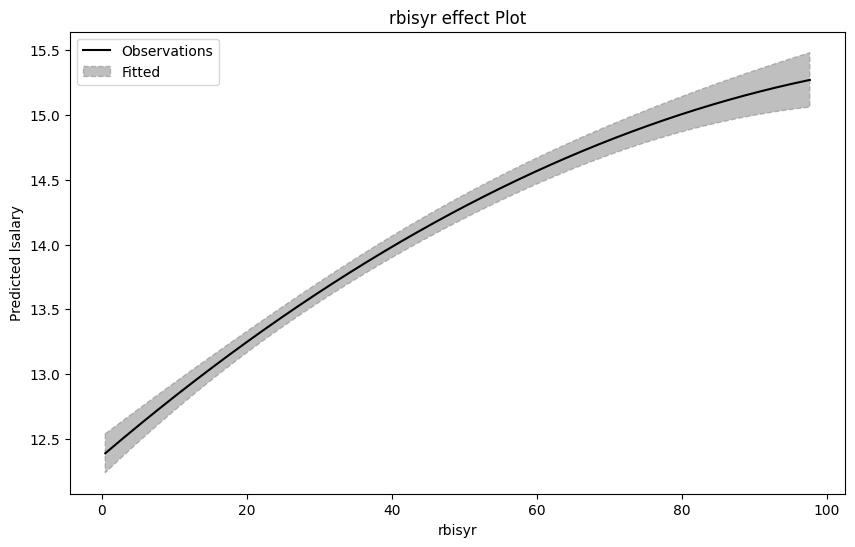

In [275]:
# Effect plot for rbisyr
xrange = np.linspace(data_final.rbisyr.min(), data_final.rbisyr.max(), 2000).reshape(2000,1)
new_data = pd.DataFrame(xrange, columns = ['rbisyr'])
new_data['years'] = data_final.years.mean()
new_data['so'] = data_final.so.mean()
new_data['outfield'] = data_final.outfield.mean()
new_data['catcher'] = data_final.catcher.mean()
predictions = ols_fit8.get_prediction(new_data)
plt.figure(figsize = (10, 6))
predictions = predictions.summary_frame(alpha=0.05)
plt.plot(new_data['rbisyr'], predictions["mean"], color = "black")

plt.title('rbisyr effect Plot')
plt.xlabel("rbisyr")
plt.ylabel("Predicted lsalary")

# confidence Intervals
plt.fill_between(new_data['rbisyr'], predictions["mean_ci_lower"], predictions["mean_ci_upper"],
                 color = "grey", linestyle = '--', alpha = .5)

# Fun fact - the legend is labelled in the order you draw each plot element!
plt.legend(["Observations", "Fitted", "Lower CI", "Upper CI","Lower PI", "Upper PI"])

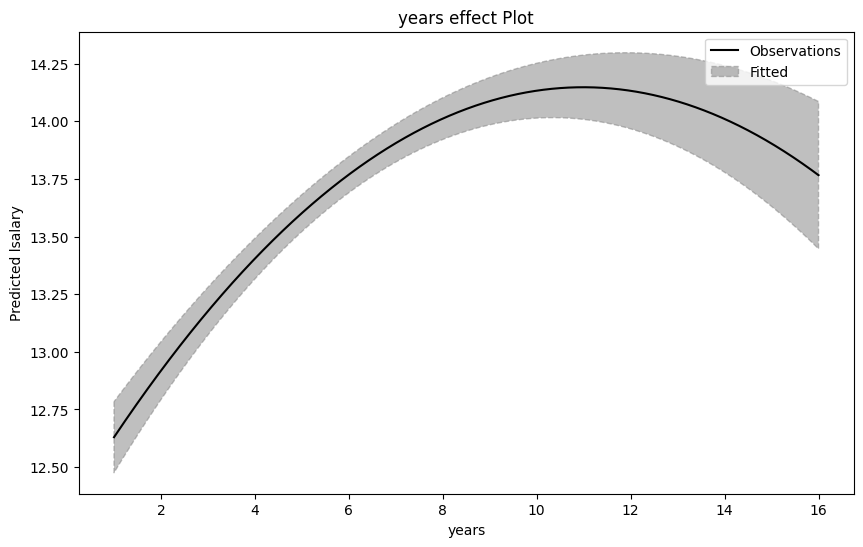

In [279]:
# Effect plot for years
xrange = np.linspace(data_final.years.min(), data_final.years.max(), 2000).reshape(2000,1)
new_data = pd.DataFrame(xrange, columns = ['years'])
new_data['rbisyr'] = data_final.rbisyr.mean()
new_data['so'] = data_final.so.mean()
new_data['outfield'] = data_final.outfield.mean()
new_data['catcher'] = data_final.catcher.mean()
predictions = ols_fit8.get_prediction(new_data)
plt.figure(figsize = (10, 6))
predictions = predictions.summary_frame(alpha=0.05)
plt.plot(new_data['years'], predictions["mean"], color = "black")

plt.title('years effect Plot')
plt.xlabel("years")
plt.ylabel("Predicted lsalary")

# confidence Intervals
plt.fill_between(new_data['years'], predictions["mean_ci_lower"], predictions["mean_ci_upper"],
                 color = "grey", linestyle = '--', alpha = .5)

# Fun fact - the legend is labelled in the order you draw each plot element!
plt.legend(["Observations", "Fitted", "Lower CI", "Upper CI","Lower PI", "Upper PI"])

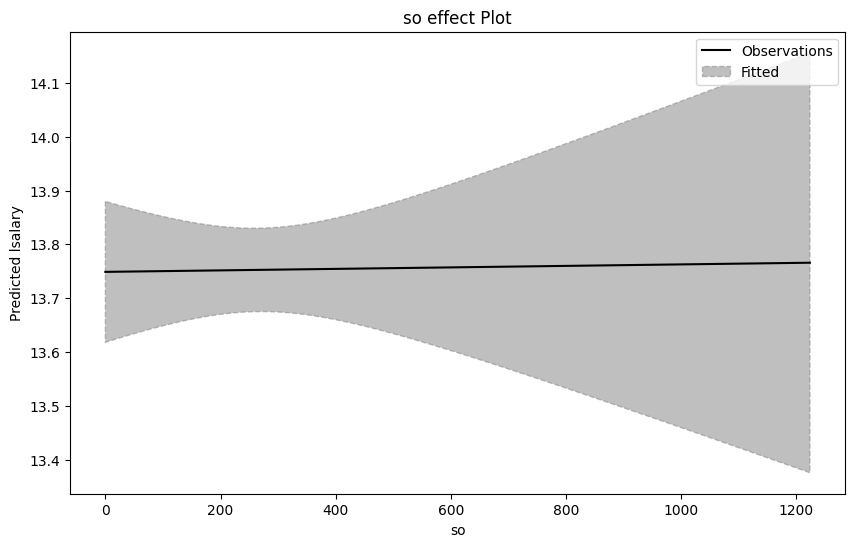

In [280]:
# Effect plot for so
xrange = np.linspace(data_final.so.min(), data_final.so.max(), 2000).reshape(2000,1)
new_data = pd.DataFrame(xrange, columns = ['so'])
new_data['rbisyr'] = data_final.rbisyr.mean()
new_data['years'] = data_final.years.mean()
new_data['outfield'] = data_final.outfield.mean()
new_data['catcher'] = data_final.catcher.mean()
predictions = ols_fit8.get_prediction(new_data)
plt.figure(figsize = (10, 6))
predictions = predictions.summary_frame(alpha=0.05)
plt.plot(new_data['so'], predictions["mean"], color = "black")

plt.title('so effect Plot')
plt.xlabel("so")
plt.ylabel("Predicted lsalary")

# confidence Intervals
plt.fill_between(new_data['so'], predictions["mean_ci_lower"], predictions["mean_ci_upper"],
                 color = "grey", linestyle = '--', alpha = .5)

# Fun fact - the legend is labelled in the order you draw each plot element!
plt.legend(["Observations", "Fitted", "Lower CI", "Upper CI","Lower PI", "Upper PI"])